# Data Challenge - Advanced Machine Learning


**The data challenge is proposed by Idemia**

## Description of the data challenge

You have at your disposal 100000 images of human faces, and their occlusion label.
The goal of this challenge is to regress the percentage of the face that is occluded.
We also want to have similar performances on female and male, the gender label is given for the train database.

Below is the formula of the evaluation score. You'll first need to compute the error made by your model for men and women separetely. The error is measured as follows

$$
 Err = \frac{\sum_{i}{w_i(p_i - GT_i)^2}}{\sum_{i}{w_i}}, w_i = \frac{1}{30} + GT_i,
$$
where $GT_i$ is the ground truth and p_i the prediction made by your model. 

Then, the final score for the leaderboard is given by

$$
Score = \frac{Err_F + Err_M}{2} + \left | Err_F - Err_M \right |,
$$
where $Err_F$ and $Err_M$ are the errors obtained for female and men, respectively.

Hereafter we show you how to load the data and run a naive baseline using a pretrained model.

### Downloading the Data:

You can download the Dataset from the below links: https://partage.imt.fr/index.php/s/mscQABX4oZxx7ax

In [1]:
# Import required libraries to run the naive baseline
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v3_small

c:\Users\ASUS\envs\virtual\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load dataframes

In [18]:
df_train = pd.read_csv("listes_training/data_100K/train_100K.csv", delimiter=' ')
df_test = pd.read_csv("listes_training/data_100K/test_students.csv", delimiter=' ')

image_dir = "crops_100K"

df_train = df_train.dropna()
df_test = df_test.dropna()

In [19]:
df_train.tail()

,filename,FaceOcclusion,gender
101340,database3/database3/m.01drbr/85-FaceId-0_align...,0.017,1.000
101341,database3/database3/m.01drbr/86-FaceId-0_align...,0.152,1.000
101342,database3/database3/m.01drbr/87-FaceId-0_align...,0.004,0.999
101343,database3/database3/m.01drbr/90-FaceId-0_align...,0.012,1.000
101344,database3/database3/m.01drbr/92-FaceId-0_align...,0.036,1.000


In [20]:
df_test.head()

,filename
0,database2/database2/test/0.jpg
1,database2/database2/test/1.jpg
2,database2/database2/test/2.jpg
3,database2/database2/test/3.jpg
4,database2/database2/test/4.jpg


<Axes: >

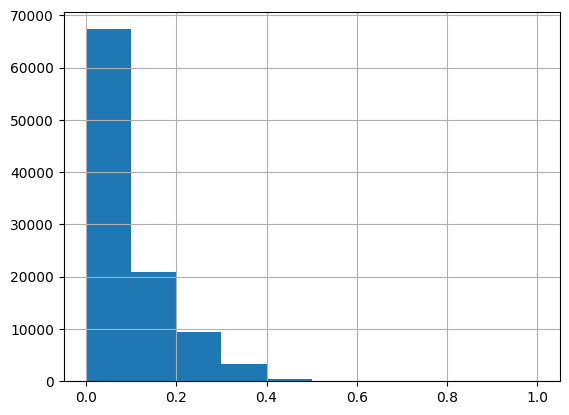

In [21]:
df_train['FaceOcclusion'].hist()

Text(0.5, 1.0, 'number of men and women in each bin of 0.01 of FaceOcclusion')

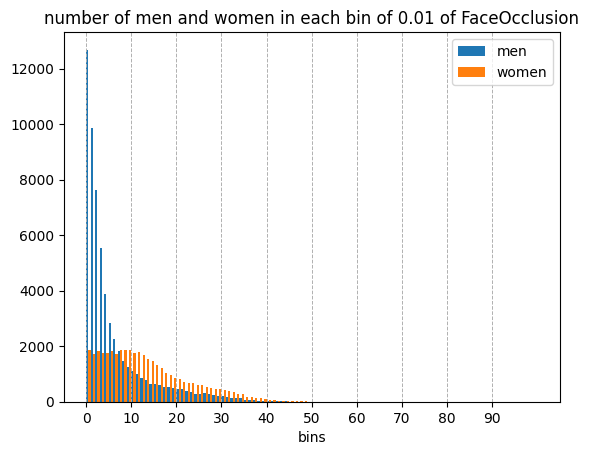

In [22]:
# Extracting histogram values for men and women
n_bins = 100
men = df_train[df_train['gender'] > 0.5]
women = df_train[df_train['gender'] < 0.5]
counts_men, bin_edges_men = np.histogram(men['FaceOcclusion'], bins=n_bins)
counts_women, bin_edges_women = np.histogram(women['FaceOcclusion'], bins=n_bins)

# Plotting the histograms
plt.bar(np.arange(n_bins)+0.25,counts_men, label = "men",width=0.5)
plt.bar(np.arange(n_bins)+0.75,counts_women, label = "women", width=0.5)
plt.legend()
plt.xlabel('bins')
plt.xticks(np.arange(0,100,10))#,np.arange(n_bins/10+1))
plt.grid(axis='x', linestyle='--', linewidth=0.7)
plt.title('number of men and women in each bin of '+ str(1/n_bins)+' of FaceOcclusion')

### Split Dataframe in train and val

In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Randomly disrupt the dataset
df_train_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)

df_train, df_val = train_test_split(df_train_shuffled, test_size=0.2, random_state=42)

# reset index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)

print("Training set:")
print(df_train.head())
print("\nValidation set:")
print(df_val.head())

Training set:
                                            filename  FaceOcclusion  gender
0                          database1/img00015966.jpg          0.015   0.997
1  database3/database3/m.01bczm/134-FaceId-0_alig...          0.011   0.998
2  database3/database3/m.01bldq/0-FaceId-0_align.jpg          0.071   0.997
3                          database1/img00017957.jpg          0.351   0.001
4                          database1/img00020727.jpg          0.128   0.001

Validation set:
                                            filename  FaceOcclusion  gender
0  database3/database3/m.01b1jr/84-FaceId-0_align...          0.061   1.000
1  database3/database3/m.018j3w/68-FaceId-0_align...          0.213   0.845
2  database3/database3/m.01bjs2/47-FaceId-0_align...          0.195   0.999
3                          database1/img00010973.jpg          0.015   0.999
4  database3/database3/m.01541z/61-FaceId-0_align...          0.108   0.001


In [24]:
len(df_train), len(df_val), len(df_test)

(81072, 20269, 30507)

### Make Dataset and Dataloader

In [8]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename

In [9]:
training_set = Dataset(df_train, image_dir)
validation_set = Dataset(df_val, image_dir)

params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}

params_val = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

training_generator = torch.utils.data.DataLoader(training_set, **params_train)
validation_generator = torch.utils.data.DataLoader(validation_set, **params_val)

In [10]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

### First step - choose proper pre-trained model

#### Mobilenet

In [ ]:
model = torchvision.models.mobilenet_v3_small(num_classes=1)
if torch.cuda.is_available():
    model.cuda()    

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10

for n in range(num_epochs):
    print(f"Epoch {n}")
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        # Transfer to GPU
        X, y = X.to(device), y.to(device)
        y = torch.reshape(y, (len(y), 1))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        if loss.isnan():
            print(filename)
            print('label', y)
            print('y_pred', y_pred)
            break

        if batch_idx % 200 == 0:
            print(loss)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

'\nmodel = torchvision.models.mobilenet_v3_small(num_classes=1)\nif torch.cuda.is_available():\n    model.cuda()    \nmodel\n'

With 10 epoches of trainning, the predictions made by Mobilenet Model values 0.0031 as final score.

#### Resnet

In [ ]:
# Load pre-trained Resnet
model = models.resnet18(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
# Modify the last layor to fit regression task
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


With 10 epoches of trainning, the predictions made by Resnet Model values 0.0022 as final score.

#### Efficientnet

In [ ]:
# Load pre-trained Efficientnet Model
model = models.efficientnet_b0(pretrained=True)
if torch.cuda.is_available():
    model.cuda()
    
# Modify the last layor to fit regression task
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


With 10 epochs of training, the predictions made by Efficientnet Model values 0.00226 as final score. This result is very close to that of the ResNet model. However, due to limited GPU resources, we decided to choose ResNet-18, as it demands fewer computational resources. Although EfficientNet has certain optimizations in terms of computational efficiency, its structure is still much more complex than ResNet-18 and requires more computational resources and memory. Furthermore, given that our dataset is of moderate size, EfficientNet is more appropriate for larger datasets

### Second step - weighted loss function - Occlusion Distribution

According to the histogram of the dataset, we can see that the data distribution is imbalanced where most data points are clustered around lower occlusion values (0 to 0.4). This skewed distribution can lead to a model that is biased towards predicting the majority class, resulting in poor performance on minority classes. To mitigate the influence of this imbalance, we decided to use a weighted loss function. This approach helps to ensure that the model does not become biased towards the majority class and making the model more robust to imbalanced data.

The dataset is separated based on the percentage of face occlusion. From the histogram, we observe that the majority of the dataset is concentrated in the range of 0 to 0.4. To balance the dataset, we implemented an unequal separation. The strategy focuses on fine granularity for lower occlusion values (0 to 0.35 or 0 to 0.4) where most data points are concentrated. By creating smaller bins in this range, we ensure that the model learns nuanced differences in low occlusion levels. The last bin groups higher occlusion values into a single category, as they are rare in the dataset. Several definitions of occlusion ranges were tested:

1. First strategy  
bins = [0, 0.05,0.1,0.15,0.2,0.25, 0.3,0.35, 1.0]  
labels = ['0-0.05', '0.05-0.1','0.1-0.15', '0.15-0.2','0.2-0.25', '0.25-0.3','0.3-0.35', '>0.35']  
The weights of the ranges are:  
{'0-0.05': 2.0659497477192805, '0.05-0.1': 5.448753276429867, '0.1-0.15': 8.054043314126764, '0.15-0.2': 12.40961273534364, '0.2-0.25': 18.91995332555426, '0.25-0.3': 26.313534566699122, '0.3-0.35': 43.37720706260032, '>0.35': 72.58012533572068}

2. Second strategy  
bins = [0, 0.04, 0.08, 0.12, 0.16, 0.2, 0.24, 0.28, 0.32, 0.36, 0.4, 1.0]  
labels = ['0-0.04', '0.04-0.08', '0.08-0.12', '0.12-0.16', '0.16-0.2', '0.2-0.24', '0.24-0.28', '0.28-0.32', '0.32-0.36', '0.36-0.4', '>0.4']  
{'0-0.04': 2.3251785355780537, '0.04-0.08': 5.733521923620933, '0.08-0.12': 8.389941012108041, '0.12-0.16': 11.44923033469849, '0.16-0.2': 16.315556449989938, '0.2-0.24': 22.620535714285715, '0.24-0.28': 30.627880619569325, '0.28-0.32': 39.18414693088449, '0.32-0.36': 69.82945736434108, '0.36-0.4': 142.73239436619718, '>0.4': 250.99690402476782}

3. Third strategy  
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]  
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']  
{'0-0.025': 3.15406162464986, '0.025-0.05': 5.988476879893633, '0.05-0.075': 9.74891774891775, '0.075-0.1': 12.35288739905531, '0.1-0.15': 8.054043314126764, '0.15-0.2': 12.40961273534364, '0.2-0.25': 18.91995332555426, '0.25-0.3': 26.313534566699122, '0.3-0.35': 43.37720706260032, '>0.35': 72.58012533572068}

In [40]:
# Range of occlusion
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']

# Seperate dataset according to their occlusion
df_train['range'] = pd.cut(df_train['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts = df_train['range'].value_counts().sort_index()
print(range_counts)

# Mean occlusion of each range
range_means = df_train.groupby('range')['FaceOcclusion'].mean()
print(range_means)

# Range's weight calculation 
total_samples = len(df_train)
# range_weights = {label: (total_samples / count) * (1/30 + mean) for label, count, mean in zip(range_counts.index, range_counts.values, range_means.values)}
range_weights = {label: total_samples / count for label, count in range_counts.items()}
print(range_weights)



0-0.025       25704
0.025-0.05    13538
0.05-0.075     8316
0.075-0.1      6563
0.1-0.15      10066
0.15-0.2       6533
0.2-0.25       4285
0.25-0.3       3081
0.3-0.35       1869
>0.35          1117
Name: range, dtype: int64
range
0-0.025       0.011090
0.025-0.05    0.036709
0.05-0.075    0.062414
0.075-0.1     0.087556
0.1-0.15      0.123740
0.15-0.2      0.173677
0.2-0.25      0.223979
0.25-0.3      0.274255
0.3-0.35      0.322576
>0.35         0.396276
Name: FaceOcclusion, dtype: float64
{'0-0.025': 3.15406162464986, '0.025-0.05': 5.988476879893633, '0.05-0.075': 9.74891774891775, '0.075-0.1': 12.35288739905531, '0.1-0.15': 8.054043314126764, '0.15-0.2': 12.40961273534364, '0.2-0.25': 18.91995332555426, '0.25-0.3': 26.313534566699122, '0.3-0.35': 43.37720706260032, '>0.35': 72.58012533572068}


Each strategy took 3 epochs training. First strategy results in 0.0024, which does not really improve the model. We supposed that the optimsation need a smaller bin so we came up with seconde strategy which end up with 0.0023. But the rarity of '>0.4' images caused some extreme weights during calculations. So for the third strategy, as their are lots of images rank in 0 - 0.1, a very fine granularity is introduced in this range. Larger granularity was taken in 0.1 - 0.35 still provide detailed segmentation, ensuring that moderate occlusion levels are well represented. The last bin '>0.35' is set for those rare samples without producing extreme weights. The result is 0.0021, which does improve the prediction.

In [ ]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
# Load pre-trained ResNet and modify it for regression
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

# Weighted loss function calculated with the occlusion range 
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges):
        loss = self.mse(inputs, targets)
        weights = torch.tensor([self.weights[str(label)] for label in ranges], device=inputs.device)
        weighted_loss = loss * weights
        return weighted_loss.mean()
    
    
# Define loss and optimizer
criterion = WeightedMSELoss(range_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        batch_ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)

        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y,batch_ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30


  0%|          | 2/8134 [00:00<12:08, 11.16it/s]

Batch 0, Loss: 0.19696271419525146


 25%|██▍       | 2003/8134 [02:30<07:43, 13.22it/s]

Batch 2000, Loss: 0.0036756948102265596


 49%|████▉     | 4003/8134 [04:32<03:18, 20.81it/s]

Batch 4000, Loss: 0.0029438012279570103


 74%|███████▍  | 6003/8134 [06:05<01:34, 22.55it/s]

Batch 6000, Loss: 0.0022785384207963943


 98%|█████████▊| 8006/8134 [07:15<00:04, 31.16it/s]

Batch 8000, Loss: 0.004136138595640659


100%|██████████| 8134/8134 [07:19<00:00, 18.51it/s]


Epoch [1/30], Loss: 0.008663700151429091
Epoch 2/30


  0%|          | 4/8134 [00:00<04:06, 33.03it/s]

Batch 0, Loss: 0.006280061788856983


 25%|██▍       | 2003/8134 [01:04<03:23, 30.14it/s]

Batch 2000, Loss: 0.0015285839326679707


 49%|████▉     | 4006/8134 [02:12<02:02, 33.80it/s]

Batch 4000, Loss: 0.001011570100672543


 74%|███████▍  | 6002/8134 [03:19<01:09, 30.67it/s]

Batch 6000, Loss: 0.00062657700618729


 98%|█████████▊| 8004/8134 [04:41<00:05, 22.08it/s]

Batch 8000, Loss: 0.000765790231525898


100%|██████████| 8134/8134 [04:47<00:00, 28.32it/s]


Epoch [2/30], Loss: 0.0023875890165622757
Epoch 3/30


  0%|          | 2/8134 [00:00<09:59, 13.56it/s]

Batch 0, Loss: 0.000599557242821902


 25%|██▍       | 2005/8134 [01:21<03:19, 30.70it/s]

Batch 2000, Loss: 0.002978698117658496


 49%|████▉     | 4005/8134 [02:37<02:38, 26.07it/s]

Batch 4000, Loss: 0.0018453423399478197


 74%|███████▍  | 6006/8134 [03:51<01:11, 29.93it/s]

Batch 6000, Loss: 0.0024055808316916227


 98%|█████████▊| 8005/8134 [05:03<00:04, 27.29it/s]

Batch 8000, Loss: 0.0006229986320249736


100%|██████████| 8134/8134 [05:07<00:00, 26.42it/s]


Epoch [3/30], Loss: 0.0018058497557045235
Epoch 4/30


  0%|          | 3/8134 [00:00<05:21, 25.32it/s]

Batch 0, Loss: 0.004467775113880634


 25%|██▍       | 2007/8134 [01:11<03:15, 31.30it/s]

Batch 2000, Loss: 0.0037112801801413298


 49%|████▉     | 4007/8134 [02:17<02:11, 31.42it/s]

Batch 4000, Loss: 0.00030401311232708395


 74%|███████▍  | 6004/8134 [03:30<01:24, 25.22it/s]

Batch 6000, Loss: 0.0011038437951356173


 98%|█████████▊| 8005/8134 [04:48<00:04, 28.55it/s]

Batch 8000, Loss: 0.001482697087340057


100%|██████████| 8134/8134 [04:53<00:00, 27.74it/s]


Epoch [4/30], Loss: 0.001436981258001065
Epoch 5/30


  0%|          | 3/8134 [00:00<05:22, 25.20it/s]

Batch 0, Loss: 0.002970050787553191


 25%|██▍       | 2003/8134 [01:15<03:37, 28.22it/s]

Batch 2000, Loss: 0.0006631716387346387


 49%|████▉     | 4007/8134 [02:39<05:37, 12.24it/s]

Batch 4000, Loss: 0.0020524661522358656


 74%|███████▍  | 6003/8134 [04:03<01:31, 23.35it/s]

Batch 6000, Loss: 0.0009898424614220858


 98%|█████████▊| 8005/8134 [05:16<00:04, 29.65it/s]

Batch 8000, Loss: 0.00029090617317706347


100%|██████████| 8134/8134 [05:20<00:00, 25.34it/s]


Epoch [5/30], Loss: 0.001217524544264967
Epoch 6/30


  0%|          | 3/8134 [00:00<04:49, 28.13it/s]

Batch 0, Loss: 0.0011804777896031737


 25%|██▍       | 2004/8134 [01:17<03:35, 28.40it/s]

Batch 2000, Loss: 0.0006324384594336152


 49%|████▉     | 4004/8134 [02:29<02:38, 26.03it/s]

Batch 4000, Loss: 0.0006233188323676586


 74%|███████▍  | 6005/8134 [03:42<01:24, 25.33it/s]

Batch 6000, Loss: 0.0012596686137840152


 98%|█████████▊| 8004/8134 [04:53<00:04, 27.92it/s]

Batch 8000, Loss: 0.0013335165567696095


100%|██████████| 8134/8134 [04:58<00:00, 27.27it/s]


Epoch [6/30], Loss: 0.000983758427065317
Epoch 7/30


  0%|          | 3/8134 [00:00<05:13, 25.97it/s]

Batch 0, Loss: 0.00034156179754063487


 25%|██▍       | 2007/8134 [01:11<03:41, 27.69it/s]

Batch 2000, Loss: 0.00035028732963837683


 49%|████▉     | 4003/8134 [02:20<02:09, 31.92it/s]

Batch 4000, Loss: 0.0007163895643316209


 74%|███████▍  | 6006/8134 [03:29<01:24, 25.04it/s]

Batch 6000, Loss: 0.0007023324142210186


 98%|█████████▊| 8006/8134 [04:42<00:04, 27.44it/s]

Batch 8000, Loss: 0.00117834925185889


100%|██████████| 8134/8134 [04:47<00:00, 28.32it/s]


Epoch [7/30], Loss: 0.000833126143569788
Epoch 8/30


  0%|          | 3/8134 [00:00<05:25, 24.97it/s]

Batch 0, Loss: 0.0004824362404178828


 25%|██▍       | 2006/8134 [01:11<03:34, 28.52it/s]

Batch 2000, Loss: 0.00034515303559601307


 49%|████▉     | 4004/8134 [02:21<02:18, 29.73it/s]

Batch 4000, Loss: 0.00036047640605829656


 74%|███████▍  | 6006/8134 [03:33<01:17, 27.52it/s]

Batch 6000, Loss: 0.00043969383114017546


 98%|█████████▊| 8003/8134 [04:45<00:04, 29.66it/s]

Batch 8000, Loss: 0.0009095155983231962


100%|██████████| 8134/8134 [04:50<00:00, 27.99it/s]


Epoch [8/30], Loss: 0.0007180302080763382
Epoch 9/30


  0%|          | 3/8134 [00:00<05:24, 25.04it/s]

Batch 0, Loss: 0.0004251011705491692


 25%|██▍       | 2004/8134 [01:10<03:27, 29.47it/s]

Batch 2000, Loss: 0.0007579195662401617


 49%|████▉     | 4006/8134 [02:20<02:27, 28.00it/s]

Batch 4000, Loss: 0.0002708105312194675


 74%|███████▍  | 6003/8134 [03:33<01:17, 27.32it/s]

Batch 6000, Loss: 0.00030453852377831936


 98%|█████████▊| 8006/8134 [04:43<00:04, 28.39it/s]

Batch 8000, Loss: 0.001624811440706253


100%|██████████| 8134/8134 [04:47<00:00, 28.25it/s]


Epoch [9/30], Loss: 0.0006127540444774084
Epoch 10/30


  0%|          | 3/8134 [00:00<05:14, 25.84it/s]

Batch 0, Loss: 0.000765616015996784


 25%|██▍       | 2006/8134 [01:10<03:41, 27.71it/s]

Batch 2000, Loss: 0.0003660854999907315


 49%|████▉     | 4005/8134 [02:22<02:29, 27.54it/s]

Batch 4000, Loss: 0.00020749241230078042


 74%|███████▍  | 6006/8134 [03:34<01:14, 28.39it/s]

Batch 6000, Loss: 0.00044313762919045985


 98%|█████████▊| 8005/8134 [04:42<00:04, 30.93it/s]

Batch 8000, Loss: 0.0006291717290878296


100%|██████████| 8134/8134 [04:47<00:00, 28.30it/s]


Epoch [10/30], Loss: 0.0005424998319852201
Epoch 11/30


  0%|          | 3/8134 [00:00<04:57, 27.31it/s]

Batch 0, Loss: 0.0008118618279695511


 25%|██▍       | 2004/8134 [01:12<03:38, 28.04it/s]

Batch 2000, Loss: 0.00014947661838959903


 49%|████▉     | 4005/8134 [02:23<02:35, 26.59it/s]

Batch 4000, Loss: 0.0011277657467871904


 74%|███████▍  | 6006/8134 [03:32<01:10, 30.07it/s]

Batch 6000, Loss: 0.00047672848450019956


 98%|█████████▊| 8005/8134 [04:43<00:04, 27.31it/s]

Batch 8000, Loss: 0.0002792036102619022


100%|██████████| 8134/8134 [04:48<00:00, 28.20it/s]


Epoch [11/30], Loss: 0.0004947764156838771
Epoch 12/30


  0%|          | 3/8134 [00:00<05:09, 26.24it/s]

Batch 0, Loss: 6.55743497190997e-05


 25%|██▍       | 2005/8134 [01:12<03:36, 28.29it/s]

Batch 2000, Loss: 0.00011713507410604507


 49%|████▉     | 4006/8134 [02:24<02:16, 30.19it/s]

Batch 4000, Loss: 0.0005065972218289971


 74%|███████▍  | 6006/8134 [03:33<01:14, 28.74it/s]

Batch 6000, Loss: 0.0016379095613956451


 98%|█████████▊| 8006/8134 [04:46<00:04, 26.71it/s]

Batch 8000, Loss: 0.00026007412816397846


100%|██████████| 8134/8134 [04:51<00:00, 27.95it/s]


Epoch [12/30], Loss: 0.0004388922938280418
Epoch 13/30


  0%|          | 3/8134 [00:00<05:21, 25.32it/s]

Batch 0, Loss: 0.00010842761548701674


 25%|██▍       | 2004/8134 [01:11<03:38, 27.99it/s]

Batch 2000, Loss: 0.00045778826461173594


 49%|████▉     | 4007/8134 [02:21<02:22, 28.89it/s]

Batch 4000, Loss: 0.0001037537949741818


 74%|███████▍  | 6004/8134 [03:36<01:30, 23.54it/s]

Batch 6000, Loss: 0.0010501713259145617


 98%|█████████▊| 8002/8134 [05:09<00:06, 20.87it/s]

Batch 8000, Loss: 0.00021800918329972774


100%|██████████| 8134/8134 [05:15<00:00, 25.80it/s]


Epoch [13/30], Loss: 0.0003992077142742702
Epoch 14/30


  0%|          | 3/8134 [00:00<06:12, 21.82it/s]

Batch 0, Loss: 0.00026974835782311857


 25%|██▍       | 2004/8134 [01:18<04:27, 22.94it/s]

Batch 2000, Loss: 0.000558379921130836


 49%|████▉     | 4005/8134 [02:42<03:21, 20.45it/s]

Batch 4000, Loss: 0.0006556856678798795


 74%|███████▍  | 6004/8134 [03:56<01:11, 29.97it/s]

Batch 6000, Loss: 0.0003923176263924688


 98%|█████████▊| 8005/8134 [05:05<00:04, 28.15it/s]

Batch 8000, Loss: 0.0007331235683523118


100%|██████████| 8134/8134 [05:09<00:00, 26.25it/s]


Epoch [14/30], Loss: 0.0003687878890905388
Epoch 15/30


  0%|          | 3/8134 [00:00<06:04, 22.32it/s]

Batch 0, Loss: 0.00020180689170956612


 25%|██▍       | 2004/8134 [01:24<04:27, 22.93it/s]

Batch 2000, Loss: 0.00011937983799725771


 49%|████▉     | 4005/8134 [02:37<02:28, 27.72it/s]

Batch 4000, Loss: 0.0002849055454134941


 74%|███████▍  | 6003/8134 [03:45<01:13, 28.91it/s]

Batch 6000, Loss: 0.0014243954792618752


 98%|█████████▊| 8004/8134 [04:56<00:04, 28.27it/s]

Batch 8000, Loss: 0.0004277208063285798


100%|██████████| 8134/8134 [05:01<00:00, 26.99it/s]


Epoch [15/30], Loss: 0.0003513346419390434
Epoch 16/30


  0%|          | 3/8134 [00:00<05:13, 25.90it/s]

Batch 0, Loss: 0.001965506700798869


 25%|██▍       | 2006/8134 [01:12<03:44, 27.31it/s]

Batch 2000, Loss: 0.00029081301181577146


 49%|████▉     | 4007/8134 [02:21<02:15, 30.39it/s]

Batch 4000, Loss: 0.0001764508051564917


 74%|███████▍  | 6005/8134 [03:31<01:14, 28.54it/s]

Batch 6000, Loss: 0.000271250813966617


 98%|█████████▊| 8005/8134 [04:43<00:04, 29.09it/s]

Batch 8000, Loss: 0.0006413119263015687


100%|██████████| 8134/8134 [04:47<00:00, 28.24it/s]


Epoch [16/30], Loss: 0.000315707303060067
Epoch 17/30


  0%|          | 3/8134 [00:00<05:27, 24.82it/s]

Batch 0, Loss: 0.00021103722974658012


 25%|██▍       | 2006/8134 [01:09<03:30, 29.17it/s]

Batch 2000, Loss: 0.0006241053342819214


 49%|████▉     | 4005/8134 [02:18<02:27, 28.03it/s]

Batch 4000, Loss: 0.00027180503821000457


 74%|███████▍  | 6006/8134 [03:30<01:16, 27.95it/s]

Batch 6000, Loss: 0.0002509230689611286


 98%|█████████▊| 8005/8134 [04:41<00:04, 29.05it/s]

Batch 8000, Loss: 0.00023648180649615824


100%|██████████| 8134/8134 [04:45<00:00, 28.48it/s]


Epoch [17/30], Loss: 0.0002855535370350449
Epoch 18/30


  0%|          | 3/8134 [00:00<04:35, 29.53it/s]

Batch 0, Loss: 0.0001133553814725019


 25%|██▍       | 2006/8134 [01:10<03:26, 29.66it/s]

Batch 2000, Loss: 0.0002637671714182943


 49%|████▉     | 4005/8134 [02:21<02:30, 27.40it/s]

Batch 4000, Loss: 0.0002701080811675638


 74%|███████▍  | 6004/8134 [03:33<01:15, 28.20it/s]

Batch 6000, Loss: 4.916790567222051e-05


 98%|█████████▊| 8005/8134 [04:44<00:04, 28.87it/s]

Batch 8000, Loss: 5.339398194337264e-05


100%|██████████| 8134/8134 [04:49<00:00, 28.13it/s]


Epoch [18/30], Loss: 0.0002731312162467213
Epoch 19/30


  0%|          | 3/8134 [00:00<05:52, 23.10it/s]

Batch 0, Loss: 0.0001270624779863283


 25%|██▍       | 2004/8134 [01:10<03:46, 27.05it/s]

Batch 2000, Loss: 0.00016548356506973505


 49%|████▉     | 4006/8134 [02:22<02:25, 28.36it/s]

Batch 4000, Loss: 0.0002666323562152684


 74%|███████▍  | 6005/8134 [03:34<01:14, 28.76it/s]

Batch 6000, Loss: 0.0001469290436943993


 98%|█████████▊| 8003/8134 [04:43<00:04, 26.98it/s]

Batch 8000, Loss: 0.0002025278372457251


100%|██████████| 8134/8134 [04:47<00:00, 28.25it/s]


Epoch [19/30], Loss: 0.0002569613291601906
Epoch 20/30


  0%|          | 3/8134 [00:00<08:46, 15.43it/s]

Batch 0, Loss: 0.00020313642744440585


 25%|██▍       | 2003/8134 [01:12<03:41, 27.65it/s]

Batch 2000, Loss: 9.105034405365586e-05


 49%|████▉     | 4004/8134 [02:24<03:24, 20.24it/s]

Batch 4000, Loss: 0.00018241901125293225


 74%|███████▍  | 6006/8134 [03:42<01:13, 29.07it/s]

Batch 6000, Loss: 3.58133802365046e-05


 98%|█████████▊| 8003/8134 [04:53<00:04, 26.90it/s]

Batch 8000, Loss: 0.00013097701594233513


100%|██████████| 8134/8134 [04:58<00:00, 27.25it/s]


Epoch [20/30], Loss: 0.00023988670567653226
Epoch 21/30


  0%|          | 3/8134 [00:00<05:09, 26.25it/s]

Batch 0, Loss: 0.00010224937432212755


 25%|██▍       | 2005/8134 [01:11<03:40, 27.84it/s]

Batch 2000, Loss: 0.0005005438579246402


 49%|████▉     | 4006/8134 [02:20<02:17, 30.07it/s]

Batch 4000, Loss: 0.00018097186693921685


 74%|███████▍  | 6003/8134 [03:30<01:15, 28.35it/s]

Batch 6000, Loss: 0.00010526071127969772


 98%|█████████▊| 8004/8134 [04:41<00:04, 29.74it/s]

Batch 8000, Loss: 0.0001401674817316234


100%|██████████| 8134/8134 [04:46<00:00, 28.39it/s]


Epoch [21/30], Loss: 0.00023050301324170142
Epoch 22/30


  0%|          | 3/8134 [00:00<05:47, 23.43it/s]

Batch 0, Loss: 0.00016294055967591703


 25%|██▍       | 2004/8134 [01:10<03:22, 30.26it/s]

Batch 2000, Loss: 0.0001940605288837105


 49%|████▉     | 4004/8134 [02:20<02:43, 25.20it/s]

Batch 4000, Loss: 0.00027136338758282363


 74%|███████▍  | 6005/8134 [03:32<01:20, 26.48it/s]

Batch 6000, Loss: 0.00012186537787783891


 98%|█████████▊| 8004/8134 [04:42<00:04, 29.26it/s]

Batch 8000, Loss: 0.00020061076793354005


100%|██████████| 8134/8134 [04:47<00:00, 28.30it/s]


Epoch [22/30], Loss: 0.00021405172277163634
Epoch 23/30


  0%|          | 3/8134 [00:00<05:03, 26.75it/s]

Batch 0, Loss: 0.00019083933148067445


 25%|██▍       | 2005/8134 [01:09<03:32, 28.90it/s]

Batch 2000, Loss: 0.0003333474160172045


 49%|████▉     | 4007/8134 [02:20<02:25, 28.29it/s]

Batch 4000, Loss: 0.00010702429426601157


 74%|███████▍  | 6003/8134 [03:31<01:15, 28.04it/s]

Batch 6000, Loss: 7.050810381770134e-05


 98%|█████████▊| 8006/8134 [04:42<00:04, 29.87it/s]

Batch 8000, Loss: 0.00017459648370277137


100%|██████████| 8134/8134 [04:46<00:00, 28.38it/s]


Epoch [23/30], Loss: 0.00020440528075809045
Epoch 24/30


  0%|          | 3/8134 [00:00<05:21, 25.30it/s]

Batch 0, Loss: 0.00012417245307005942


 25%|██▍       | 2005/8134 [01:11<03:38, 28.04it/s]

Batch 2000, Loss: 3.7284207792254165e-05


 49%|████▉     | 4005/8134 [02:26<02:30, 27.45it/s]

Batch 4000, Loss: 9.274465992348269e-05


 74%|███████▍  | 6004/8134 [03:37<01:14, 28.66it/s]

Batch 6000, Loss: 0.00016365251212846488


 98%|█████████▊| 8004/8134 [04:47<00:04, 27.85it/s]

Batch 8000, Loss: 0.000300298590445891


100%|██████████| 8134/8134 [04:52<00:00, 27.85it/s]


Epoch [24/30], Loss: 0.00019470286100642313
Epoch 25/30


  0%|          | 3/8134 [00:00<05:24, 25.06it/s]

Batch 0, Loss: 0.0003536646254360676


 25%|██▍       | 2003/8134 [01:12<03:44, 27.32it/s]

Batch 2000, Loss: 0.00018556123541202396


 49%|████▉     | 4004/8134 [02:24<02:24, 28.65it/s]

Batch 4000, Loss: 0.0007389270467683673


 74%|███████▍  | 6004/8134 [03:34<01:14, 28.71it/s]

Batch 6000, Loss: 4.355733472038992e-05


 98%|█████████▊| 8006/8134 [04:46<00:04, 27.93it/s]

Batch 8000, Loss: 4.619021274265833e-05


100%|██████████| 8134/8134 [04:50<00:00, 27.95it/s]


Epoch [25/30], Loss: 0.0001846118809139595
Epoch 26/30


  0%|          | 3/8134 [00:00<05:35, 24.22it/s]

Batch 0, Loss: 0.00020821367797907442


 25%|██▍       | 2004/8134 [01:13<03:43, 27.49it/s]

Batch 2000, Loss: 0.0002155859983759001


 49%|████▉     | 4004/8134 [02:23<02:26, 28.25it/s]

Batch 4000, Loss: 0.00011086853919550776


 74%|███████▍  | 6005/8134 [03:35<01:16, 27.79it/s]

Batch 6000, Loss: 0.00031811135704629123


 98%|█████████▊| 8005/8134 [04:48<00:04, 27.46it/s]

Batch 8000, Loss: 0.00017834386380854994


100%|██████████| 8134/8134 [04:52<00:00, 27.76it/s]


Epoch [26/30], Loss: 0.00017831802392390567
Epoch 27/30


  0%|          | 3/8134 [00:00<05:29, 24.67it/s]

Batch 0, Loss: 0.00022318596893455833


 25%|██▍       | 2004/8134 [01:11<03:37, 28.18it/s]

Batch 2000, Loss: 0.0001267857151106


 49%|████▉     | 4003/8134 [02:21<02:56, 23.40it/s]

Batch 4000, Loss: 0.0001367959484923631


 74%|███████▍  | 6005/8134 [03:34<01:15, 28.21it/s]

Batch 6000, Loss: 0.00041218483238480985


 98%|█████████▊| 8003/8134 [04:45<00:04, 29.36it/s]

Batch 8000, Loss: 0.00011331287532811984


100%|██████████| 8134/8134 [04:50<00:00, 28.00it/s]


Epoch [27/30], Loss: 0.00017193965580892674
Epoch 28/30


  0%|          | 3/8134 [00:00<05:27, 24.83it/s]

Batch 0, Loss: 0.0002464409335516393


 25%|██▍       | 2003/8134 [01:09<03:47, 26.90it/s]

Batch 2000, Loss: 0.00011680079478537664


 49%|████▉     | 4005/8134 [02:22<02:32, 27.01it/s]

Batch 4000, Loss: 0.0006756220827810466


 74%|███████▍  | 6004/8134 [03:34<01:12, 29.46it/s]

Batch 6000, Loss: 0.00019243215501774102


 98%|█████████▊| 8006/8134 [04:44<00:04, 28.35it/s]

Batch 8000, Loss: 2.7362926630303264e-05


100%|██████████| 8134/8134 [04:48<00:00, 28.17it/s]


Epoch [28/30], Loss: 0.00016577750769563408
Epoch 29/30


  0%|          | 3/8134 [00:00<05:45, 23.56it/s]

Batch 0, Loss: 8.660031016916037e-05


 25%|██▍       | 2006/8134 [01:11<03:44, 27.27it/s]

Batch 2000, Loss: 0.00014356971951201558


 49%|████▉     | 4004/8134 [02:26<02:26, 28.15it/s]

Batch 4000, Loss: 2.831527126545552e-05


 74%|███████▍  | 6004/8134 [03:38<01:20, 26.50it/s]

Batch 6000, Loss: 0.00029615472885780036


 98%|█████████▊| 8004/8134 [04:50<00:04, 26.35it/s]

Batch 8000, Loss: 9.37974764383398e-05


100%|██████████| 8134/8134 [04:54<00:00, 27.59it/s]


Epoch [29/30], Loss: 0.00016479830185334483
Epoch 30/30


  0%|          | 3/8134 [00:00<05:51, 23.15it/s]

Batch 0, Loss: 0.0003447572817094624


 25%|██▍       | 2006/8134 [01:13<03:43, 27.47it/s]

Batch 2000, Loss: 3.721221582964063e-05


 49%|████▉     | 4004/8134 [02:24<02:26, 28.17it/s]

Batch 4000, Loss: 8.083605644060299e-05


 74%|███████▍  | 6004/8134 [03:34<01:16, 27.73it/s]

Batch 6000, Loss: 4.723964957520366e-05


 98%|█████████▊| 8004/8134 [04:47<00:04, 27.26it/s]

Batch 8000, Loss: 0.0002614716941025108


100%|██████████| 8134/8134 [04:52<00:00, 27.81it/s]

Epoch [30/30], Loss: 0.00015145263596616759
Training complete


'\n\n\n# 加载预训练的EfficientNet\nmodel = models.efficientnet_b0(pretrained=True)\nif torch.cuda.is_available():\n    model.cuda()\n    \n# 修改最后的全连接层\nnum_features = model.classifier[1].in_features\nmodel.classifier[1] = nn.Linear(num_features, 1)\n\n# 将模型移动到GPU\ndevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")\nmodel = model.to(device)\n\n# 定义损失函数和优化器\ncriterion = nn.MSELoss()\noptimizer = optim.Adam(model.parameters(), lr=1e-4)\n\n\nnum_epochs = 10\nfor epoch in range(num_epochs):\n    print(f"Epoch {epoch+1}/{num_epochs}")\n    model.train()\n    running_loss = 0.0\n    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):\n        X, y = X.to(device), y.to(device).view(-1, 1)\n        optimizer.zero_grad()\n        y_pred = model(X)\n        loss = criterion(y_pred, y)\n        loss.backward()\n        optimizer.step()\n        running_loss += loss.item()\n\n        if batch_idx % 2000 == 0:\n            print

According to the process of the training we can see the reduction of the loss.  
training epochs  |  best result  
10               |  0.00215    
20               |  0.0017     
30               |  0.00249


### Third step - weighted loss function - Gender Distribution

The histogramme also shows the gender differences between dataset(mainly on data distribution), so we tried to handel this problem by adding gender based weights in weighted loss function.

In [22]:
# Define gender weights
gender_counts = df_train['gender'].apply(lambda x: 'male' if x > 0.5 else 'female').value_counts()
total_gender_samples = len(df_train)
gender_weights = {'male': 1, 'female': 1.05}
print(gender_weights)


class WeightedMSELoss2(nn.Module):
    def __init__(self, range_weights, gender_weights):
        super(WeightedMSELoss2, self).__init__()
        self.range_weights = range_weights
        self.gender_weights = gender_weights
        self.mse = nn.MSELoss(reduction='none')

    def forward(self, inputs, targets, ranges, genders):
        loss = self.mse(inputs, targets)
        range_weights = torch.tensor([self.range_weights[str(label)] for label in ranges], device=inputs.device)
        gender_weights = torch.tensor([self.gender_weights['male'] if gender > 0.5 else self.gender_weights['female'] for gender in genders], device=inputs.device)
        total_weights = range_weights * gender_weights
        weighted_loss = loss * total_weights
        return weighted_loss.mean()




{'male': 1, 'female': 1.05}


In [23]:
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

criterion = WeightedMSELoss2(range_weights, gender_weights)

num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)   
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges,gender)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/3


  0%|          | 3/8134 [00:01<54:49,  2.47it/s]  

Batch 0, Loss: 0.05580662935972214


  1%|▏         | 113/8134 [00:10<11:59, 11.14it/s]


KeyboardInterrupt: 

Several gender weights has been tested with 3 epochs running:  score | weights  

- 0.0025   {'male': 1.6632542108610466, 'female': 2.5077175291533917}(calculated by gender distribution)

- 0.0028   {'male': 1, 'female': 1.5}

- 0.0025   {'male': 1, 'female': 1.1}

- 0.0031   {'male': 1, 'female': 1.2}

- 0.00188 / 0.00437    {'male': 1, 'female': 1.05} 

- 0.0035   {'male': 1, 'female': 1.01}

- 0.0036   {'male': 1, 'female': 1.04}

- 0.00236   {'male': 1, 'female': 1.06}

- 0.003   {'male': 1, 'female': 1.055}

- 0.0037   {'male': 1, 'female': 1.08}

We can see that certain weight do optimise the performance but the result is not stable. It may because the introduction of gender weights changes the shape of the loss function and the current learning rate may be too high, causing the model to fluctuate during training and not converge. But we did not test the reduction of the learning rate as short of GPU resource. Another reason might because the gender weight made the loss weight too extreme for the model.

For {'male': 1, 'female': 1.05}, 10 epochs ended up with 0.003/0.0022 and 20 epochs ended up with 0.0024.

We also considered a weight with error calculation weight given by the texte, but results does not optimised.
range_weights = {label: (total_samples / count) * (1/30 + mean) for label, count, mean in zip(range_counts.index, range_counts.values, range_means.values)}
mean is the occlusions' mean for samples in this range.



### Fourth step - Fine-tuning and Drop out

#### Fine-Tuning

In [28]:
#  fine-tuning
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

for param in model.parameters():
    param.requires_grad = False

# Allow the parameters of the last layer (usually the classifier) to be updated (i.e., require gradients) 
# so that they can be adapted on new tasks to suit the specific requirements of the new data.

for param in model.fc.parameters():
    param.requires_grad = True

model = model.to(device)

criterion = WeightedMSELoss(range_weights)

optimizer = optim.Adam(model.parameters(), lr=1e-4)


num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)

        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


NameError: name 'models' is not defined

With range-based weight, fine-tuning result:  
epochs | score  
3 | 0.017            
50 | 0.0114  



With range-gender-based weight, gender weights {'male': 1, 'female': 1.05} fine-tuning result:  
epochs | score  
3 | 0.015  
10 | 0.024             
50 | 0.034   

Fine-tuning not really useful in this case

#### Drop out

In [39]:
#  drop out

model = models.resnet18(pretrained=True)

# Modify last layor to regression layor and add drop out
model.fc = nn.Sequential(
    nn.Dropout(0.5),  # dropout layor, probability = 0.5
    nn.Linear(model.fc.in_features, 1)
)

model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = WeightedMSELoss(range_weights)


num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y, ranges)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20


  0%|          | 4/8134 [00:00<12:10, 11.13it/s]

Batch 0, Loss: 15.267549514770508


 25%|██▍       | 2004/8134 [01:02<03:17, 30.96it/s]

Batch 2000, Loss: 0.42806276679039


 49%|████▉     | 4006/8134 [02:08<02:12, 31.08it/s]

Batch 4000, Loss: 0.25640085339546204


 74%|███████▍  | 6005/8134 [03:13<01:12, 29.53it/s]

Batch 6000, Loss: 0.05989650636911392


 98%|█████████▊| 8004/8134 [04:18<00:04, 29.54it/s]

Batch 8000, Loss: 0.05621059983968735


100%|██████████| 8134/8134 [04:22<00:00, 30.93it/s]


Epoch [1/20], Loss: 0.42840806654362645
Epoch 2/20


  0%|          | 4/8134 [00:00<04:09, 32.56it/s]

Batch 0, Loss: 0.01868419349193573


 25%|██▍       | 2006/8134 [01:05<03:16, 31.18it/s]

Batch 2000, Loss: 0.015036902390420437


 49%|████▉     | 4005/8134 [02:09<02:18, 29.81it/s]

Batch 4000, Loss: 0.008262800052762032


 74%|███████▍  | 6004/8134 [03:14<01:09, 30.80it/s]

Batch 6000, Loss: 0.0041946046985685825


 98%|█████████▊| 8003/8134 [04:19<00:04, 29.92it/s]

Batch 8000, Loss: 0.019365474581718445


100%|██████████| 8134/8134 [04:23<00:00, 30.84it/s]


Epoch [2/20], Loss: 0.021690598195735874
Epoch 3/20


  0%|          | 3/8134 [00:00<04:59, 27.15it/s]

Batch 0, Loss: 0.00967356190085411


 25%|██▍       | 2005/8134 [01:06<03:27, 29.60it/s]

Batch 2000, Loss: 0.0042714145965874195


 49%|████▉     | 4004/8134 [02:14<02:12, 31.14it/s]

Batch 4000, Loss: 0.007352720946073532


 74%|███████▍  | 6006/8134 [03:20<01:07, 31.75it/s]

Batch 6000, Loss: 0.005717090796679258


 98%|█████████▊| 8006/8134 [04:26<00:04, 31.83it/s]

Batch 8000, Loss: 0.005611411761492491


100%|██████████| 8134/8134 [04:30<00:00, 30.09it/s]


Epoch [3/20], Loss: 0.01578387569517945
Epoch 4/20


  0%|          | 3/8134 [00:00<05:01, 26.93it/s]

Batch 0, Loss: 0.004084839019924402


 25%|██▍       | 2007/8134 [01:04<03:20, 30.55it/s]

Batch 2000, Loss: 0.01618725061416626


 49%|████▉     | 4007/8134 [02:09<02:11, 31.46it/s]

Batch 4000, Loss: 0.028187762945890427


 74%|███████▍  | 6007/8134 [03:14<01:08, 31.20it/s]

Batch 6000, Loss: 0.019871985539793968


 98%|█████████▊| 8004/8134 [04:18<00:03, 34.42it/s]

Batch 8000, Loss: 0.009454959072172642


100%|██████████| 8134/8134 [04:22<00:00, 31.01it/s]


Epoch [4/20], Loss: 0.013138551468398929
Epoch 5/20


  0%|          | 4/8134 [00:00<03:58, 34.10it/s]

Batch 0, Loss: 0.022172274067997932


 25%|██▍       | 2004/8134 [00:58<02:59, 34.18it/s]

Batch 2000, Loss: 0.004855080973356962


 49%|████▉     | 4004/8134 [01:58<02:02, 33.59it/s]

Batch 4000, Loss: 0.021481094881892204


 74%|███████▍  | 6004/8134 [02:57<01:02, 33.95it/s]

Batch 6000, Loss: 0.003280205652117729


 98%|█████████▊| 8004/8134 [03:57<00:03, 34.52it/s]

Batch 8000, Loss: 0.0026057790964841843


100%|██████████| 8134/8134 [04:01<00:00, 33.74it/s]


Epoch [5/20], Loss: 0.011273464684408608
Epoch 6/20


  0%|          | 4/8134 [00:00<03:58, 34.08it/s]

Batch 0, Loss: 0.00292032933793962


 25%|██▍       | 2004/8134 [00:58<02:58, 34.25it/s]

Batch 2000, Loss: 0.012506358325481415


 49%|████▉     | 4004/8134 [01:58<02:02, 33.68it/s]

Batch 4000, Loss: 0.004851578734815121


 74%|███████▍  | 6004/8134 [02:57<01:02, 33.88it/s]

Batch 6000, Loss: 0.018865851685404778


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.41it/s]

Batch 8000, Loss: 0.010352060198783875


100%|██████████| 8134/8134 [04:00<00:00, 33.80it/s]


Epoch [6/20], Loss: 0.010064232911010945
Epoch 7/20


  0%|          | 4/8134 [00:00<03:59, 33.90it/s]

Batch 0, Loss: 0.004892949014902115


 25%|██▍       | 2004/8134 [00:58<03:00, 33.88it/s]

Batch 2000, Loss: 0.010518033988773823


 49%|████▉     | 4004/8134 [01:58<02:02, 33.70it/s]

Batch 4000, Loss: 0.0027951321098953485


 74%|███████▍  | 6004/8134 [02:57<01:03, 33.62it/s]

Batch 6000, Loss: 0.02301129512488842


 98%|█████████▊| 8006/8134 [03:57<00:03, 34.17it/s]

Batch 8000, Loss: 0.008728132583200932


100%|██████████| 8134/8134 [04:00<00:00, 33.76it/s]


Epoch [7/20], Loss: 0.008977919056965118
Epoch 8/20


  0%|          | 4/8134 [00:00<04:00, 33.78it/s]

Batch 0, Loss: 0.022113069891929626


 25%|██▍       | 2004/8134 [00:58<02:59, 34.21it/s]

Batch 2000, Loss: 0.008798264898359776


 49%|████▉     | 4004/8134 [01:58<02:03, 33.47it/s]

Batch 4000, Loss: 0.06013529747724533


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.18it/s]

Batch 6000, Loss: 0.0032645189203321934


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.30it/s]

Batch 8000, Loss: 0.009555799886584282


100%|██████████| 8134/8134 [04:00<00:00, 33.82it/s]


Epoch [8/20], Loss: 0.008002885207963094
Epoch 9/20


  0%|          | 4/8134 [00:00<03:56, 34.44it/s]

Batch 0, Loss: 0.002787854289636016


 25%|██▍       | 2004/8134 [00:58<02:59, 34.22it/s]

Batch 2000, Loss: 0.002888432703912258


 49%|████▉     | 4004/8134 [01:58<02:02, 33.71it/s]

Batch 4000, Loss: 0.003753554541617632


 74%|███████▍  | 6004/8134 [02:57<01:03, 33.58it/s]

Batch 6000, Loss: 0.0010205958969891071


 98%|█████████▊| 8004/8134 [03:56<00:03, 33.98it/s]

Batch 8000, Loss: 0.0036240178160369396


100%|██████████| 8134/8134 [04:00<00:00, 33.79it/s]


Epoch [9/20], Loss: 0.006929047087420316
Epoch 10/20


  0%|          | 4/8134 [00:00<04:02, 33.52it/s]

Batch 0, Loss: 0.005915378220379353


 25%|██▍       | 2004/8134 [00:58<02:58, 34.25it/s]

Batch 2000, Loss: 0.009877221658825874


 49%|████▉     | 4004/8134 [01:58<02:02, 33.68it/s]

Batch 4000, Loss: 0.001173321157693863


 74%|███████▍  | 6004/8134 [02:57<01:03, 33.53it/s]

Batch 6000, Loss: 0.004705245140939951


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.25it/s]

Batch 8000, Loss: 0.005396649241447449


100%|██████████| 8134/8134 [04:00<00:00, 33.81it/s]


Epoch [10/20], Loss: 0.006534409088759205
Epoch 11/20


  0%|          | 4/8134 [00:00<04:01, 33.71it/s]

Batch 0, Loss: 0.004780503921210766


 25%|██▍       | 2004/8134 [00:58<03:00, 34.04it/s]

Batch 2000, Loss: 0.025105591863393784


 49%|████▉     | 4004/8134 [01:58<02:03, 33.33it/s]

Batch 4000, Loss: 0.005131879821419716


 74%|███████▍  | 6004/8134 [02:57<01:03, 33.73it/s]

Batch 6000, Loss: 0.0017253521364182234


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.46it/s]

Batch 8000, Loss: 0.001838391530327499


100%|██████████| 8134/8134 [04:00<00:00, 33.80it/s]


Epoch [11/20], Loss: 0.005793640040017878
Epoch 12/20


  0%|          | 4/8134 [00:00<03:56, 34.30it/s]

Batch 0, Loss: 0.002577665727585554


 25%|██▍       | 2004/8134 [00:58<02:59, 34.17it/s]

Batch 2000, Loss: 0.007277908269315958


 49%|████▉     | 4004/8134 [01:58<02:03, 33.44it/s]

Batch 4000, Loss: 0.0012244642712175846


 74%|███████▍  | 6004/8134 [02:57<01:02, 33.81it/s]

Batch 6000, Loss: 0.0017833533929660916


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.45it/s]

Batch 8000, Loss: 0.0012638811022043228


100%|██████████| 8134/8134 [04:00<00:00, 33.82it/s]


Epoch [12/20], Loss: 0.005284388310115911
Epoch 13/20


  0%|          | 4/8134 [00:00<04:07, 32.83it/s]

Batch 0, Loss: 0.012854410335421562


 25%|██▍       | 2004/8134 [00:58<02:59, 34.10it/s]

Batch 2000, Loss: 0.0015813233330845833


 49%|████▉     | 4004/8134 [01:58<02:03, 33.42it/s]

Batch 4000, Loss: 0.0001751612580846995


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.19it/s]

Batch 6000, Loss: 0.0034577748738229275


 98%|█████████▊| 8004/8134 [03:56<00:03, 32.71it/s]

Batch 8000, Loss: 0.011318592354655266


100%|██████████| 8134/8134 [04:00<00:00, 33.79it/s]


Epoch [13/20], Loss: 0.005022394601663302
Epoch 14/20


  0%|          | 4/8134 [00:00<04:00, 33.75it/s]

Batch 0, Loss: 0.0014130474301055074


 25%|██▍       | 2004/8134 [00:58<03:00, 33.94it/s]

Batch 2000, Loss: 0.002498292364180088


 49%|████▉     | 4004/8134 [01:58<02:06, 32.68it/s]

Batch 4000, Loss: 0.0029757351148873568


 74%|███████▍  | 6004/8134 [02:58<01:03, 33.75it/s]

Batch 6000, Loss: 0.003691788762807846


 98%|█████████▊| 8004/8134 [03:57<00:03, 34.14it/s]

Batch 8000, Loss: 0.006621856242418289


100%|██████████| 8134/8134 [04:01<00:00, 33.74it/s]


Epoch [14/20], Loss: 0.004550673794541125
Epoch 15/20


  0%|          | 4/8134 [00:00<04:05, 33.05it/s]

Batch 0, Loss: 0.002635990036651492


 25%|██▍       | 2004/8134 [00:58<02:59, 34.14it/s]

Batch 2000, Loss: 0.0029074533376842737


 49%|████▉     | 4004/8134 [01:58<02:02, 33.59it/s]

Batch 4000, Loss: 0.009413843974471092


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.23it/s]

Batch 6000, Loss: 0.0005970244528725743


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.36it/s]

Batch 8000, Loss: 0.0018280200893059373


100%|██████████| 8134/8134 [04:00<00:00, 33.81it/s]


Epoch [15/20], Loss: 0.004054113596520475
Epoch 16/20


  0%|          | 4/8134 [00:00<03:58, 34.15it/s]

Batch 0, Loss: 0.006578168831765652


 25%|██▍       | 2004/8134 [00:58<02:58, 34.29it/s]

Batch 2000, Loss: 0.004432089626789093


 49%|████▉     | 4004/8134 [01:58<02:03, 33.42it/s]

Batch 4000, Loss: 0.003263872815296054


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.09it/s]

Batch 6000, Loss: 0.0037871715612709522


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.16it/s]

Batch 8000, Loss: 0.0014822824159637094


100%|██████████| 8134/8134 [04:00<00:00, 33.82it/s]


Epoch [16/20], Loss: 0.0036786203612555126
Epoch 17/20


  0%|          | 4/8134 [00:00<04:06, 32.98it/s]

Batch 0, Loss: 0.0023309867829084396


 25%|██▍       | 2004/8134 [00:58<03:00, 34.05it/s]

Batch 2000, Loss: 0.001029598293825984


 49%|████▉     | 4004/8134 [01:58<02:02, 33.60it/s]

Batch 4000, Loss: 0.0002936279051937163


 74%|███████▍  | 6004/8134 [02:58<01:03, 33.47it/s]

Batch 6000, Loss: 0.020739372819662094


 98%|█████████▊| 8004/8134 [03:57<00:03, 34.03it/s]

Batch 8000, Loss: 0.0012428967747837305


100%|██████████| 8134/8134 [04:01<00:00, 33.73it/s]


Epoch [17/20], Loss: 0.003611133917420102
Epoch 18/20


  0%|          | 4/8134 [00:00<04:03, 33.33it/s]

Batch 0, Loss: 0.0019305262248963118


 25%|██▍       | 2004/8134 [00:59<03:00, 33.90it/s]

Batch 2000, Loss: 0.004420418757945299


 49%|████▉     | 4004/8134 [01:58<02:04, 33.12it/s]

Batch 4000, Loss: 0.002078540623188019


 74%|███████▍  | 6004/8134 [02:58<01:03, 33.68it/s]

Batch 6000, Loss: 0.00039543042657896876


 98%|█████████▊| 8004/8134 [03:57<00:03, 33.92it/s]

Batch 8000, Loss: 0.0005526941968128085


100%|██████████| 8134/8134 [04:01<00:00, 33.65it/s]


Epoch [18/20], Loss: 0.0031179286827419175
Epoch 19/20


  0%|          | 4/8134 [00:00<04:00, 33.85it/s]

Batch 0, Loss: 0.0016916845925152302


 25%|██▍       | 2004/8134 [00:59<02:58, 34.25it/s]

Batch 2000, Loss: 0.000946396088693291


 49%|████▉     | 4004/8134 [01:58<02:02, 33.68it/s]

Batch 4000, Loss: 0.0007213230710476637


 74%|███████▍  | 6004/8134 [02:58<01:03, 33.65it/s]

Batch 6000, Loss: 0.002294881734997034


 98%|█████████▊| 8004/8134 [03:57<00:03, 34.12it/s]

Batch 8000, Loss: 0.000780145637691021


100%|██████████| 8134/8134 [04:01<00:00, 33.71it/s]


Epoch [19/20], Loss: 0.003019244676825761
Epoch 20/20


  0%|          | 4/8134 [00:00<03:59, 33.97it/s]

Batch 0, Loss: 0.004671720787882805


 25%|██▍       | 2004/8134 [00:58<02:59, 34.23it/s]

Batch 2000, Loss: 0.018216747790575027


 49%|████▉     | 4004/8134 [01:58<02:12, 31.20it/s]

Batch 4000, Loss: 0.0015973813133314252


 74%|███████▍  | 6004/8134 [02:57<01:02, 34.02it/s]

Batch 6000, Loss: 0.002447527600452304


 98%|█████████▊| 8004/8134 [03:56<00:03, 34.24it/s]

Batch 8000, Loss: 0.000471621984615922


100%|██████████| 8134/8134 [04:00<00:00, 33.82it/s]

Epoch [20/20], Loss: 0.0029681516054291747
Training complete


With range-based weight, fine-tuning result:  
epochs | score  
3 | 0.00455            
10 | 0.00457    
20 | 0.002559

Does have optimization affect with augmentation the epoch but score lower than normal model without dropout

### Fifth step - 2 model black and white / color

In [29]:

from PIL import Image
import numpy as np

# Verify if the image is a grayscale image or not.
# If the values of R, G and B channels are equal, it means that the image is a grey scale map
def is_grayscale(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    if np.array_equal(img_np[..., 0], img_np[..., 1]) and np.array_equal(img_np[..., 0], img_np[..., 2]):
        return True
    return False

# grayscale image = True, coloful image = False
df_train['is_grayscale'] = df_train['filename'].apply(lambda x: is_grayscale(f"{image_dir}/{x}"))

# split dataset grayscale and dataset colorful
df_train_grayscale = df_train[df_train['is_grayscale']]
df_train_color = df_train[~df_train['is_grayscale']]

# clean is_grayscale column
df_train_grayscale.drop(columns=['is_grayscale'], inplace=True)
df_train_color.drop(columns=['is_grayscale'], inplace=True)



C:\Users\ASUS\AppData\Local\Temp\ipykernel_1596\1566326449.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_grayscale.drop(columns=['is_grayscale'], inplace=True)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_1596\1566326449.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_color.drop(columns=['is_grayscale'], inplace=True)


In [30]:
df_train_grayscale.head()

,filename,FaceOcclusion,gender,range
6,database3/database3/m.01dmm2/6-FaceId-0_align.jpg,0.227,0.000,0.2-0.25
14,database3/database3/m.019pkm/91-FaceId-0_align...,0.016,0.994,0-0.025
17,database3/database3/m.0183dl/55-FaceId-0_align...,0.209,0.998,0.2-0.25
30,database3/database3/m.0197gg/7-FaceId-0_align.jpg,0.088,1.000,0.075-0.1
41,database3/database3/m.015t_m/70-FaceId-0_align...,0.001,0.982,0-0.025


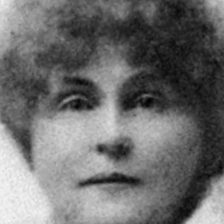

database3/database3/m.01dmm2/6-FaceId-0_align.jpg 0.227 0.0


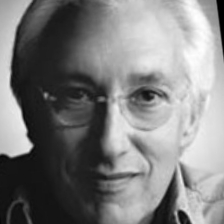

database3/database3/m.019pkm/91-FaceId-0_align.jpg 0.016 0.994


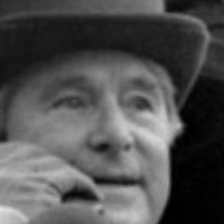

database3/database3/m.0183dl/55-FaceId-0_align.jpg 0.209 0.998


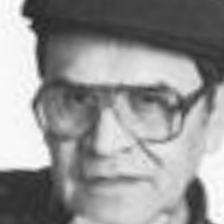

database3/database3/m.0197gg/7-FaceId-0_align.jpg 0.088 1.0


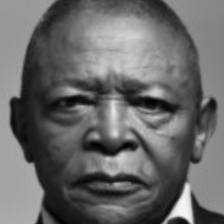

database3/database3/m.015t_m/70-FaceId-0_align.jpg 0.001 0.982


In [32]:
for idx, row in df_train_grayscale[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

In [31]:
df_train_color.head()

,filename,FaceOcclusion,gender,range
0,database1/img00015966.jpg,0.015,0.997,0-0.025
1,database3/database3/m.01bczm/134-FaceId-0_alig...,0.011,0.998,0-0.025
2,database3/database3/m.01bldq/0-FaceId-0_align.jpg,0.071,0.997,0.05-0.075
3,database1/img00017957.jpg,0.351,0.001,>0.35
4,database1/img00020727.jpg,0.128,0.001,0.1-0.15


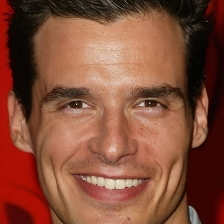

database1/img00015966.jpg 0.015 0.997


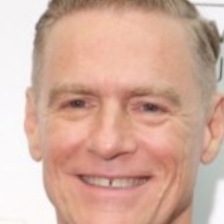

database3/database3/m.01bczm/134-FaceId-0_align.jpg 0.011 0.998


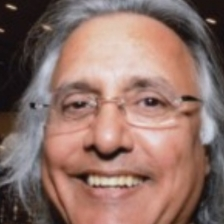

database3/database3/m.01bldq/0-FaceId-0_align.jpg 0.071 0.997


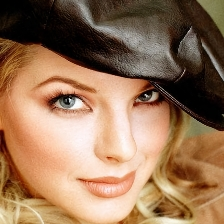

database1/img00017957.jpg 0.351 0.001


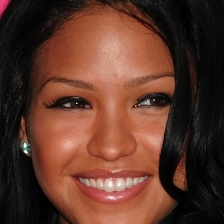

database1/img00020727.jpg 0.128 0.001


In [33]:
for idx, row in df_train_color[:5].iterrows():
    filename = row['filename']
    occlusion = row['FaceOcclusion']
    gender = row['gender']
    img2display = Image.open(f"{image_dir}/{filename}")
    display(img2display)
    print(filename, occlusion, gender)

In [34]:
df_train_grayscale = df_train_grayscale.reset_index(drop=True)
df_train_color= df_train_color.reset_index(drop=True)

In [36]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")
        y = row['FaceOcclusion']
        gender = row['gender']

        X = self.transform(img)
        y = np.float32(y)

        return X, y, gender, filename
    
    
    
params_train = {'batch_size': 8,
          'shuffle': True,
          'num_workers': 0}


train_grayscale_dataset = Dataset(df_train_grayscale, image_dir)
train_color_dataset = Dataset(df_train_color, image_dir)

train_grayscale_loader = torch.utils.data.DataLoader(train_grayscale_dataset, **params_train)
train_color_loader = torch.utils.data.DataLoader(train_color_dataset, **params_train)

In [35]:
bins = [0, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 1.0]
labels = ['0-0.025', '0.025-0.05', '0.05-0.075', '0.075-0.1', '0.1-0.15', '0.15-0.2', '0.2-0.25', '0.25-0.3', '0.3-0.35', '>0.35']


df_train_grayscale['range'] = pd.cut(df_train_grayscale['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts_G = df_train_grayscale['range'].value_counts().sort_index()
print(range_counts_G)

df_train_color['range'] = pd.cut(df_train_color['FaceOcclusion'], bins=bins, labels=labels, include_lowest=True)
range_counts = df_train_color['range'].value_counts().sort_index()
print(range_counts)


total_samples_G = len(df_train_grayscale)
total_samples = len(df_train_color)

range_weights_G = {label: 0.1*total_samples_G / count for label, count in range_counts_G.items()}
print("Weights for grayscale dataset")
print(range_weights_G)

range_weights = {label: 0.1*total_samples / count for label, count in range_counts.items()}
print("Weights for color dataset")
print(range_weights)

0-0.025       4336
0.025-0.05    2150
0.05-0.075    1150
0.075-0.1      850
0.1-0.15      1121
0.15-0.2       684
0.2-0.25       453
0.25-0.3       314
0.3-0.35       140
>0.35           70
Name: range, dtype: int64
0-0.025       21368
0.025-0.05    11388
0.05-0.075     7166
0.075-0.1      5713
0.1-0.15       8945
0.15-0.2       5849
0.2-0.25       3832
0.25-0.3       2767
0.3-0.35       1729
>0.35          1047
Name: range, dtype: int64
Weights for grayscale dataset
{'0-0.025': 0.2598708487084871, '0.025-0.05': 0.524093023255814, '0.05-0.075': 0.9798260869565217, '0.075-0.1': 1.3256470588235294, '0.1-0.15': 1.0051739518287244, '0.15-0.2': 1.6473684210526316, '0.2-0.25': 2.487417218543046, '0.25-0.3': 3.5885350318471336, '0.3-0.35': 8.048571428571428, '>0.35': 16.097142857142856}
Weights for color dataset
{'0-0.025': 0.3266754024709847, '0.025-0.05': 0.6129610115911486, '0.05-0.075': 0.9740999162712811, '0.075-0.1': 1.221844915105899, '0.1-0.15': 0.7803689211850197, '0.15-0.2': 1.19343

In [151]:
model_grayscale = models.resnet18(pretrained=True)
model_grayscale.fc = nn.Linear(model_grayscale.fc.in_features, 1)
model_grayscale = model_grayscale.to(device)


# Loss function for grayscale model
criterion1 = WeightedMSELoss(range_weights_G)
# Loss function for color model
criterion2 = WeightedMSELoss(range_weights)

optimizer_grayscale = optim.Adam(model_grayscale.parameters(), lr=1e-4)


# Grayscale model training
num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model_grayscale.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(train_grayscale_loader), total=len(train_grayscale_loader)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)
        
        optimizer_grayscale.zero_grad()
        y_pred = model_grayscale(X)
        #loss = criterion2(y_pred, y, ranges,gender)

        loss = criterion1(y_pred, y, ranges)

        loss.backward()
        optimizer_grayscale.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_grayscale_loader)}")

print('Training complete for grayscale images')




Epoch 1/30


  0%|          | 4/1399 [00:00<02:10, 10.71it/s]

Batch 0, Loss: 1.3213802576065063


100%|██████████| 1399/1399 [00:42<00:00, 32.86it/s]


Epoch [1/30], Loss: 0.06435434885201223
Epoch 2/30


  0%|          | 4/1399 [00:00<00:44, 31.01it/s]

Batch 0, Loss: 0.014091639779508114


100%|██████████| 1399/1399 [00:41<00:00, 33.63it/s]


Epoch [2/30], Loss: 0.009456573159958478
Epoch 3/30


  0%|          | 4/1399 [00:00<00:43, 32.30it/s]

Batch 0, Loss: 0.0041917297057807446


100%|██████████| 1399/1399 [00:41<00:00, 34.03it/s]


Epoch [3/30], Loss: 0.006385085682257853
Epoch 4/30


  0%|          | 4/1399 [00:00<00:44, 31.39it/s]

Batch 0, Loss: 0.004782931413501501


100%|██████████| 1399/1399 [00:41<00:00, 34.02it/s]


Epoch [4/30], Loss: 0.005253582213415892
Epoch 5/30


  0%|          | 4/1399 [00:00<00:44, 31.35it/s]

Batch 0, Loss: 0.00654596695676446


100%|██████████| 1399/1399 [00:41<00:00, 33.96it/s]


Epoch [5/30], Loss: 0.004646440232343611
Epoch 6/30


  0%|          | 4/1399 [00:00<00:41, 33.38it/s]

Batch 0, Loss: 0.004722067154943943


100%|██████████| 1399/1399 [00:41<00:00, 33.45it/s]


Epoch [6/30], Loss: 0.003830650004049333
Epoch 7/30


  0%|          | 3/1399 [00:00<00:51, 27.31it/s]

Batch 0, Loss: 0.0025724542792886496


100%|██████████| 1399/1399 [00:41<00:00, 33.32it/s]


Epoch [7/30], Loss: 0.0032634106809082803
Epoch 8/30


  0%|          | 4/1399 [00:00<00:45, 30.72it/s]

Batch 0, Loss: 0.00654796464368701


100%|██████████| 1399/1399 [00:41<00:00, 33.64it/s]


Epoch [8/30], Loss: 0.0032805221100281885
Epoch 9/30


  0%|          | 4/1399 [00:00<00:41, 33.85it/s]

Batch 0, Loss: 0.002720773685723543


100%|██████████| 1399/1399 [00:41<00:00, 33.95it/s]


Epoch [9/30], Loss: 0.0025399046774472714
Epoch 10/30


  0%|          | 4/1399 [00:00<00:42, 32.85it/s]

Batch 0, Loss: 0.001639888039790094


100%|██████████| 1399/1399 [00:41<00:00, 34.07it/s]


Epoch [10/30], Loss: 0.0023379933286784534
Epoch 11/30


  0%|          | 4/1399 [00:00<00:43, 31.93it/s]

Batch 0, Loss: 0.0017073386115953326


100%|██████████| 1399/1399 [00:41<00:00, 33.95it/s]


Epoch [11/30], Loss: 0.0017746100387664304
Epoch 12/30


  0%|          | 4/1399 [00:00<00:43, 31.88it/s]

Batch 0, Loss: 0.0058404067531228065


100%|██████████| 1399/1399 [00:41<00:00, 33.68it/s]


Epoch [12/30], Loss: 0.001741189347504809
Epoch 13/30


  0%|          | 3/1399 [00:00<00:46, 29.75it/s]

Batch 0, Loss: 0.004075688309967518


100%|██████████| 1399/1399 [00:41<00:00, 33.53it/s]


Epoch [13/30], Loss: 0.0016608106716408419
Epoch 14/30


  0%|          | 4/1399 [00:00<00:44, 31.41it/s]

Batch 0, Loss: 0.00043782201828435063


100%|██████████| 1399/1399 [00:41<00:00, 33.85it/s]


Epoch [14/30], Loss: 0.0012900036812525358
Epoch 15/30


  0%|          | 4/1399 [00:00<00:43, 31.92it/s]

Batch 0, Loss: 0.0003222721570637077


100%|██████████| 1399/1399 [00:41<00:00, 33.96it/s]


Epoch [15/30], Loss: 0.001287898941090478
Epoch 16/30


  0%|          | 4/1399 [00:00<00:42, 32.44it/s]

Batch 0, Loss: 0.0011848456924781203


100%|██████████| 1399/1399 [00:41<00:00, 34.02it/s]


Epoch [16/30], Loss: 0.0010900623209226035
Epoch 17/30


  0%|          | 3/1399 [00:00<00:47, 29.31it/s]

Batch 0, Loss: 0.00299807614646852


100%|██████████| 1399/1399 [00:41<00:00, 33.97it/s]


Epoch [17/30], Loss: 0.001070955078980117
Epoch 18/30


  0%|          | 4/1399 [00:00<00:44, 31.67it/s]

Batch 0, Loss: 0.0009708483121357858


100%|██████████| 1399/1399 [00:41<00:00, 33.41it/s]


Epoch [18/30], Loss: 0.0009788442013848153
Epoch 19/30


  0%|          | 4/1399 [00:00<00:44, 31.61it/s]

Batch 0, Loss: 0.0008317406172864139


100%|██████████| 1399/1399 [00:41<00:00, 33.50it/s]


Epoch [19/30], Loss: 0.0008545504799239993
Epoch 20/30


  0%|          | 4/1399 [00:00<00:43, 32.09it/s]

Batch 0, Loss: 0.0015135708963498473


100%|██████████| 1399/1399 [00:41<00:00, 33.94it/s]


Epoch [20/30], Loss: 0.0008704475436438156
Epoch 21/30


  0%|          | 4/1399 [00:00<00:42, 32.85it/s]

Batch 0, Loss: 0.0001895688328659162


100%|██████████| 1399/1399 [00:41<00:00, 33.99it/s]


Epoch [21/30], Loss: 0.0007076304609758487
Epoch 22/30


  0%|          | 4/1399 [00:00<00:44, 31.40it/s]

Batch 0, Loss: 0.0003273725160397589


100%|██████████| 1399/1399 [00:41<00:00, 34.01it/s]


Epoch [22/30], Loss: 0.0007174957737477571
Epoch 23/30


  0%|          | 4/1399 [00:00<00:43, 32.21it/s]

Batch 0, Loss: 0.0006595979211851954


100%|██████████| 1399/1399 [00:41<00:00, 33.85it/s]


Epoch [23/30], Loss: 0.0007459152909591762
Epoch 24/30


  0%|          | 4/1399 [00:00<00:43, 31.71it/s]

Batch 0, Loss: 0.0003030762018170208


100%|██████████| 1399/1399 [00:41<00:00, 33.49it/s]


Epoch [24/30], Loss: 0.0007538534052366336
Epoch 25/30


  0%|          | 3/1399 [00:00<00:53, 26.30it/s]

Batch 0, Loss: 0.0010182502446696162


100%|██████████| 1399/1399 [00:41<00:00, 33.64it/s]


Epoch [25/30], Loss: 0.0006974568076019554
Epoch 26/30


  0%|          | 4/1399 [00:00<00:42, 33.02it/s]

Batch 0, Loss: 0.000614842982031405


100%|██████████| 1399/1399 [00:41<00:00, 33.95it/s]


Epoch [26/30], Loss: 0.0005840969907441781
Epoch 27/30


  0%|          | 4/1399 [00:00<00:43, 31.99it/s]

Batch 0, Loss: 0.001172104268334806


100%|██████████| 1399/1399 [00:41<00:00, 34.01it/s]


Epoch [27/30], Loss: 0.0005654873694493745
Epoch 28/30


  0%|          | 4/1399 [00:00<00:42, 33.15it/s]

Batch 0, Loss: 0.00031566384132020175


100%|██████████| 1399/1399 [00:41<00:00, 33.50it/s]


Epoch [28/30], Loss: 0.0005085504843794728
Epoch 29/30


  0%|          | 4/1399 [00:00<00:43, 32.25it/s]

Batch 0, Loss: 0.0003668545978143811


100%|██████████| 1399/1399 [00:41<00:00, 33.52it/s]


Epoch [29/30], Loss: 0.0004959060941673813
Epoch 30/30


  0%|          | 4/1399 [00:00<00:42, 32.58it/s]

Batch 0, Loss: 0.0003383164876140654


100%|██████████| 1399/1399 [00:41<00:00, 33.52it/s]

Epoch [30/30], Loss: 0.0005348303537681306
Training complete for grayscale images


In [41]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

# Color model training

model_color = models.resnet18(pretrained=True)
model_color.fc = nn.Linear(model_color.fc.in_features, 1)
model_color = model_color.to(device)

criterion2 = WeightedMSELoss(range_weights)

optimizer_color = optim.Adam(model_color.parameters(), lr=1e-4)

num_epochs = 30
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model_color.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(train_color_loader), total=len(train_color_loader)):
        X, y = X.to(device), y.to(device).view(-1, 1)
        ranges = pd.cut(y.cpu().numpy().flatten(), bins=bins, labels=labels, include_lowest=True)

        optimizer_color.zero_grad()
        y_pred = model_color(X)
        #loss = criterion2(y_pred, y, ranges,gender)
        loss = criterion2(y_pred, y, range_weights)
        loss.backward()
        optimizer_color.step()
        running_loss += loss.item()
        
        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_color_loader)}")

print('Training complete for color images')

c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ASUS\envs\virtual\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/30


  0%|          | 5/8726 [00:01<23:07,  6.28it/s]  

Batch 0, Loss: 12.328246116638184


  1%|▏         | 126/8726 [00:04<05:24, 26.50it/s]


KeyboardInterrupt: 

With range-based weight, result:  
epochs | best score  
3 | 0.016      
10 | 0.0013        
30 | 0.00089  
The score varies for same model and same epoch.
We also tried a prediction with grayscale model and normal model(to predict color image in order to have more robust) with 30 epochs training, values 0.00375.  


With range-gender-based weight, gender weights {'male': 1, 'female': 1.05} fine-tuning result:  
epochs | score  
10 | 0.0034 

### Face mesh(doesn't work really well)

In [48]:
import cv2
import mediapipe as mp
import time
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from PIL import Image
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, min_detection_confidence=0.5)

def get_face_landmarks(image):
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            landmarks = [(lm.x, lm.y, lm.z) for lm in face_landmarks.landmark]
            return landmarks
    return None



In [50]:
class FaceOcclusionDataset(Dataset):
    def __init__(self, df, image_dir):
        self.image_dir = image_dir
        self.df = df
        self.transform = transforms.ToTensor()
         
    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        row = self.df.loc[index]
        filename = row['filename']
        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        y = row['FaceOcclusion']
        gender = row['gender']
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  
        y = torch.tensor([y], dtype=torch.float32)
        return X, y, gender, filename


training_set = FaceOcclusionDataset(df_train, image_dir)
validation_set = FaceOcclusionDataset(df_val, image_dir)

params_train = {'batch_size': 8, 'shuffle': True, 'num_workers': 0}
params_val = {'batch_size': 8, 'shuffle': False, 'num_workers': 0}

training_generator = DataLoader(training_set, **params_train)
validation_generator = DataLoader(validation_set, **params_val)


In [55]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(468*3, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


  0%|          | 0/8134 [00:00<?, ?it/s]


ValueError: too many values to unpack (expected 2)

In [54]:
num_epochs = 3
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    running_loss = 0.0
    for batch_idx, (X, y, gender, filename) in tqdm(enumerate(training_generator), total=len(training_generator)):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 2000 == 0:
            print(f"Batch {batch_idx}, Loss: {loss.item()}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(training_generator)}")

print('Training complete')


Epoch 1/3


  0%|          | 0/8134 [00:00<?, ?it/s]


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [8, 1404]

## Evaluate metric on validation split

In [17]:
def error_fn(df):
    pred = df.loc[:, "pred"]
    ground_truth = df.loc[:, "target"]
    weight = 1/30 + ground_truth

    return np.sum(((pred - ground_truth)**2) * weight, axis=0) / np.sum(weight, axis=0)

def metric_fn(female, male):
    err_male = error_fn(male)
    err_female = error_fn(female)
    print("Male error: ", err_male)
    print("Female error: ", err_female)
    
    return (err_male + err_female) / 2 + abs(err_male - err_female)

In [19]:
results_df.head()

,pred,target,gender
0,0.027467,0.000,0.987
1,0.014575,0.015,0.997
2,0.012943,0.017,0.998
3,0.027558,0.020,0.997
4,0.050533,0.000,0.999


<Axes: >

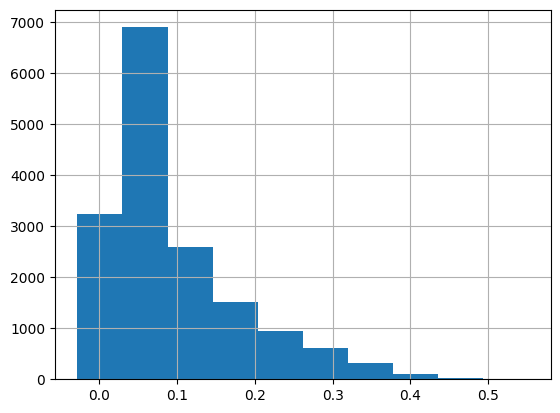

In [20]:
results_df['pred'].hist()

100%|██████████| 2034/2034 [00:59<00:00, 34.13it/s]


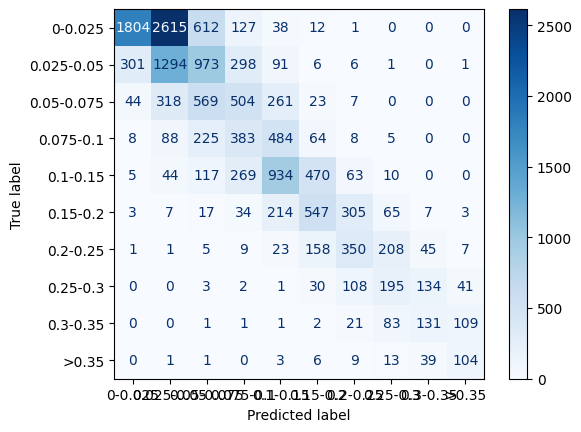

In [21]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from tqdm import tqdm
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

results_list = []
for batch_idx, (X, y, gender, filename) in tqdm(enumerate(validation_generator), total=len(validation_generator)):
    X, y = X.to(device), y.to(device).view(-1, 1)
    y_pred = model(X)
    for i in range(len(X)):
        true_range = pd.cut([float(y[i])], bins=bins, labels=labels, include_lowest=True)[0]
        pred_range = pd.cut([float(y_pred[i])], bins=bins, labels=labels, include_lowest=True)[0]
        results_list.append({'true_range': str(true_range), 'pred_range': str(pred_range),'pred': float(y_pred[i]),
                                  'target': float(y[i]),
                                  'gender': float(gender[i])})


results_df = pd.DataFrame(results_list)

y_true = results_df['true_range']
y_pred = results_df['pred_range']
cm = confusion_matrix(y_true, y_pred, labels=labels)

print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()




In [22]:
print(f"Classification Report:\n")
print(classification_report(y_true, y_pred, labels=labels, target_names=labels))

Classification Report:

              precision    recall  f1-score   support

     0-0.025       0.83      0.34      0.48      5339
  0.025-0.05       0.30      0.43      0.35      2978
  0.05-0.075       0.23      0.33      0.27      1727
   0.075-0.1       0.24      0.30      0.26      1265
    0.1-0.15       0.46      0.49      0.47      1912
    0.15-0.2       0.42      0.46      0.43      1202
    0.2-0.25       0.40      0.43      0.42       807
    0.25-0.3       0.34      0.38      0.36       514
    0.3-0.35       0.37      0.38      0.37       349
       >0.35       0.39      0.59      0.47       176

   micro avg       0.39      0.39      0.39     16269
   macro avg       0.40      0.41      0.39     16269
weighted avg       0.50      0.39      0.40     16269



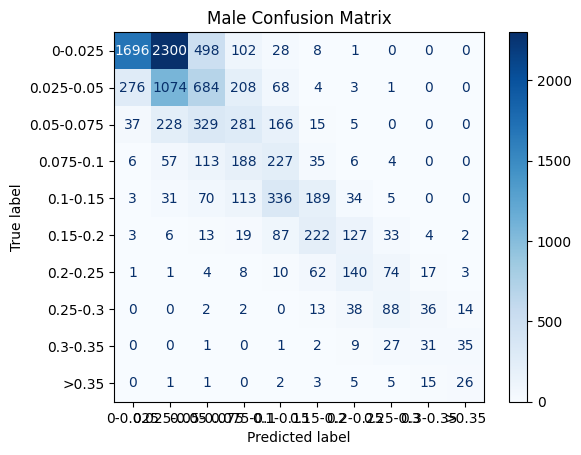

Classification Report for Male Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.84      0.36      0.50      4759
  0.025-0.05       0.29      0.46      0.36      2325
  0.05-0.075       0.19      0.31      0.24      1062
   0.075-0.1       0.20      0.30      0.24       636
    0.1-0.15       0.36      0.43      0.39       781
    0.15-0.2       0.40      0.43      0.42       516
    0.2-0.25       0.38      0.44      0.41       320
    0.25-0.3       0.37      0.46      0.41       193
    0.3-0.35       0.30      0.29      0.30       106
       >0.35       0.33      0.45      0.38        58

   micro avg       0.39      0.38      0.39     10756
   macro avg       0.37      0.39      0.36     10756
weighted avg       0.53      0.38      0.41     10756



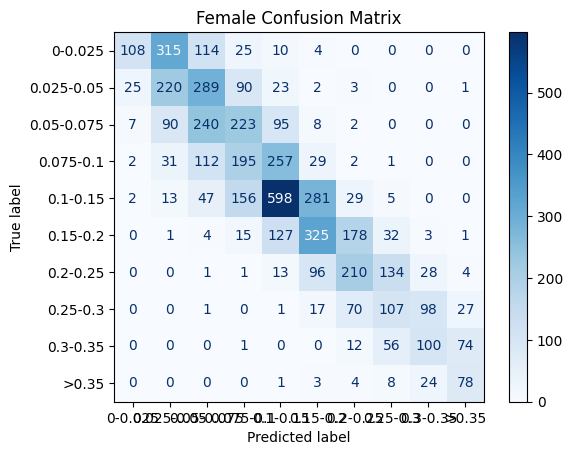

Classification Report for Female Confusion Matrix:

              precision    recall  f1-score   support

     0-0.025       0.75      0.19      0.30       580
  0.025-0.05       0.33      0.34      0.33       653
  0.05-0.075       0.30      0.36      0.33       665
   0.075-0.1       0.28      0.31      0.29       629
    0.1-0.15       0.53      0.53      0.53      1131
    0.15-0.2       0.42      0.47      0.45       686
    0.2-0.25       0.41      0.43      0.42       487
    0.25-0.3       0.31      0.33      0.32       321
    0.3-0.35       0.40      0.41      0.40       243
       >0.35       0.42      0.66      0.51       118

   micro avg       0.40      0.40      0.40      5513
   macro avg       0.41      0.40      0.39      5513
weighted avg       0.43      0.40      0.39      5513



In [23]:
results_male = results_df.loc[results_df["gender"] > 0.5]
results_female = results_df.loc[results_df["gender"] < 0.5]
# print(results_male)
# print(results_female)

def plot_confusion_matrix(results, title):
    y_true = results['true_range']
    y_pred = results['pred_range']
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    print(f"Classification Report for {title}:\n")
    print(classification_report(y_true, y_pred, labels=labels, target_names=labels))


# Male confusion matrix
plot_confusion_matrix(results_male, "Male Confusion Matrix")

# Female confusion matrix
plot_confusion_matrix(results_female, "Female Confusion Matrix")

In [24]:
metric_fn(results_male, results_female)

0.002332612480355155
0.0028553619690595594


0.0031167367134117617

## Evaluating your Test DataSet

In [157]:
# original
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, filename
    
    
test_set = Dataset_test(df_test, image_dir)

params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_generator = torch.utils.data.DataLoader(test_set, **params_test)

results_list = []
for batch_idx, (X, filename) in tqdm(enumerate(test_generator), total=len(test_generator)):
        X = X.to(device)
        y_pred = model(X)
        for i in range(len(X)):

            results_list.append({'pred': float(y_pred[i])
                                 })
test_df = pd.DataFrame(results_list)

In [33]:
### face mesh

'''
class faceDataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']

        img_path = f"{self.image_dir}/{filename}"
        img = cv2.imread(img_path)
        landmarks = get_face_landmarks(img)
        
        if landmarks:
            X = torch.tensor(landmarks).view(-1)
        else:
            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标
        

        return X, filename

'''

'\nclass faceDataset_test(torch.utils.data.Dataset):\n    \'Characterizes a dataset for PyTorch\'\n    def __init__(self, df, image_dir):\n         \'Initialization\'\n         self.image_dir = image_dir\n         self.df = df\n         self.transform = transforms.ToTensor()\n         \n    def __len__(self):\n        \'Denotes the total number of samples\'\n        return len(self.df)\n\n    def __getitem__(self, index):\n        \'Generates one sample of data\'\n        # Select sample\n        row = self.df.loc[index]\n        filename = row[\'filename\']\n\n        img_path = f"{self.image_dir}/{filename}"\n        img = cv2.imread(img_path)\n        landmarks = get_face_landmarks(img)\n        \n        if landmarks:\n            X = torch.tensor(landmarks).view(-1)\n        else:\n            X = torch.zeros(468*3)  # 468个特征点，每个特征点有x, y, z三个坐标\n        \n\n        return X, filename\n\n'

In [94]:
def is_grayscale(image_path):
    img = Image.open(image_path).convert('RGB')
    img_np = np.array(img)
    if np.array_equal(img_np[..., 0], img_np[..., 1]) and np.array_equal(img_np[..., 0], img_np[..., 2]):
        return True
    return False


df_test['is_grayscale'] = df_test['filename'].apply(lambda x: is_grayscale(f"{image_dir}/{x}"))
df_test.head()


,filename,is_grayscale
0,database2/database2/test/0.jpg,False
1,database2/database2/test/1.jpg,False
2,database2/database2/test/2.jpg,True
3,database2/database2/test/3.jpg,False
4,database2/database2/test/4.jpg,False


In [162]:
# 2 models test set
class Dataset_test(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, df, image_dir):
         'Initialization'
         self.image_dir = image_dir
         self.df = df
         self.transform = transforms.ToTensor()
         
    def __len__(self):
        'Denotes the total number of samples'
        return len(self.df)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        row = self.df.loc[index]
        filename = row['filename']
        is_gray = row['is_grayscale']
        # Load data and get label
        img = Image.open(f"{image_dir}/{filename}")

        X = self.transform(img)

        return X, is_gray, filename

test_set = Dataset_test(df_test, image_dir)
params_test = {'batch_size': 8,
          'shuffle': False,
          'num_workers': 0}

test_loader = torch.utils.data.DataLoader(test_set, **params_test)



results_list = []
for batch_idx, (X, is_gray, filename) in tqdm(enumerate(test_loader), total=len(test_loader)):
    X = X.to(device)
    for i in range(len(X)):  
        if is_gray[i].item():  
            y_pred = model_grayscale(X[i].unsqueeze(0)) 
        else:
            y_pred = model(X[i].unsqueeze(0)) 
        

        results_list.append({'pred': float(y_pred.squeeze().item())})


test_df = pd.DataFrame(results_list)

100%|██████████| 3814/3814 [02:41<00:00, 23.57it/s]


In [160]:
test_df.head()

,pred
0,0.280279
1,0.344143
2,0.361664
3,0.297884
4,0.383106


### Preparing your file for Submission

In [163]:
test_df.to_csv("Data_Challenge.csv", header = None, index = None)